# 시계열 예측

- 시계열 값의 미래 예측 (time series forecasting)
 - 수요예측, 매출예측, 생산/물류/재고 예측, 리스크/장애/이상 예측 등

## 접근법
- (1) 자신의 과거 값만 사용하여 미래 값을 예측하는 (y-y 모델)
  - 선형예측, ARIMA, Prophet 등 수리 모델 기반의 단변수 예측 모델 사용
  - 랜덤한 성분은 예측이 안된다 (트렌드, 주기성 만 예측 가능)
- (2) 다양한 외부 특성들을 사용하여 예측하는 (X-y 모델)
  - y에 영향을 주는 다양한 환경 변수들을 입력 특성 X에 포함한다
  - X에 y의 과거 값들도 포함시킬 수 있다 (위의 1을 포함하는 셈!)
  - 입력 X에 변형된 특성을 추가할 수 있다 (이동 평균, 이동 분산 등)
  - 카테고리 변수들이 많으면 X-y 모델이 잘 동작한다 (선형계열 모델은 카테고리 변수를 표현하는데 한계가 있다)
  - 임의의 머신러닝 모델을 사용할 수 있다
- (3) 샘플(행) 단위로 예측하는 것이 아니라 입력신호의 누적 효과(여러 행)를 반영하는 (신경망 모델)
  - LSTM을 주로 사용한다
  - 좋은 성능을 얻으려면 학습 데이터가 충분히 많아야 한다

# import

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score
from datetime import datetime
%config InlineBackend.figure_format = 'retina'
import matplotlib
# matplotlib.rcParams['figure.figsize'] = (8,6)
# matplotlib.rcParams.update({'font.size': 13})

## 데이터
- 서울 자전거 대여수 예측

- Date : year-month-day
- Rented Bike count - Count of bikes rented at each hour
- Hour - Hour of he day
- Temperature-Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [24]:
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/SeoulBikeData.csv",
                header=None)
print(df.shape)
df[:3]

(8760, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


# X-y 모델

- 여러 컬럼 값을 사용한다


In [25]:
df.columns = ['date', 'count', 'hour', 'temp', 'humidity',
       'wind', 'visibility', 'dew',
       'solar', 'rainfall', 'snowfall', 'seasons',
       'holiday', 'functioning'] #컬럼이름은 되도록 띄어쓰기랑 콤마는 제거하고 하도록..

In [5]:
df[:3]  #Header컬럼 명이 변경되어있음.

,date,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,snowfall,seasons,holiday,functioning
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [6]:
df.isnull().sum().sum()  #결측치 확인. 0 이므로 결측치가 없다.

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         8760 non-null   object 
 1   count        8760 non-null   int64  
 2   hour         8760 non-null   int64  
 3   temp         8760 non-null   float64
 4   humidity     8760 non-null   int64  
 5   wind         8760 non-null   float64
 6   visibility   8760 non-null   int64  
 7   dew          8760 non-null   float64
 8   solar        8760 non-null   float64
 9   rainfall     8760 non-null   float64
 10  snowfall     8760 non-null   float64
 11  seasons      8760 non-null   object 
 12  holiday      8760 non-null   object 
 13  functioning  8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


## datetime 분해

In [26]:
df.loc[:,"date"] = pd.to_datetime(df.date, dayfirst=True)  #문자열 -> 연/월/시분초 로  Convert  : to _date , dayfirst = True 는 처음에 나오는게 날짜인지 월인지
df[:3]

<ipython-input-26-dc5f2d85a84b>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,"date"] = pd.to_datetime(df.date, dayfirst=True)  #문자열 -> 연/월/시분초 로  Convert  : to _date , dayfirst = True 는 처음에 나오는게 날짜인지 월인지


,date,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,snowfall,seasons,holiday,functioning
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [10]:
df.info()   #위와 달리 Date의 type이 object => datetime64 로 바뀌어잇음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         8760 non-null   datetime64[ns]
 1   count        8760 non-null   int64         
 2   hour         8760 non-null   int64         
 3   temp         8760 non-null   float64       
 4   humidity     8760 non-null   int64         
 5   wind         8760 non-null   float64       
 6   visibility   8760 non-null   int64         
 7   dew          8760 non-null   float64       
 8   solar        8760 non-null   float64       
 9   rainfall     8760 non-null   float64       
 10  snowfall     8760 non-null   float64       
 11  seasons      8760 non-null   object        
 12  holiday      8760 non-null   object        
 13  functioning  8760 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(4), object(3)
memory usage: 958.2+ KB


In [11]:
df.date.min(), df.date.max()

(Timestamp('2017-12-01 00:00:00'), Timestamp('2018-11-30 00:00:00'))

In [13]:
# 빠진 날자가 있는지 확인
pd.date_range(start = '2017-12-01', end = '2018-11-29' ).difference(df.date)   #date_range는 특정 기간동안동안의 날짜를 만들고, 아까 만든 DataFrame에서 뺌. 날짜데이터의 결측치를 확인.

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

## datetime 날짜 데이터 분해

In [27]:
df["d-year"] = df["date"].dt.year   #dt는 내부변수. dt.year는 년도만 뽑아냄. dt.month는 월만 뽑아냄.
df["d-month"] = df["date"].dt.month
df["d-day"] = df["date"].dt.day
df["d-dayofweek"] = df["date"].dt.dayofweek

df[:3]

#df[:3].T

,date,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,snowfall,seasons,holiday,functioning,d-year,d-month,d-day,d-dayofweek
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4


In [28]:
df = pd.get_dummies(df, ['seasons','holiday', 'functioning'])

df[:5]

,date,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,...,d-day,d-dayofweek,seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_Holiday,holiday_No Holiday,functioning_No,functioning_Yes
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,1,4,0,0,0,1,0,1,0,1
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,1,4,0,0,0,1,0,1,0,1
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,1,4,0,0,0,1,0,1,0,1
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,1,4,0,0,0,1,0,1,0,1
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,1,4,0,0,0,1,0,1,0,1


<Axes: xlabel='hour', ylabel='count'>

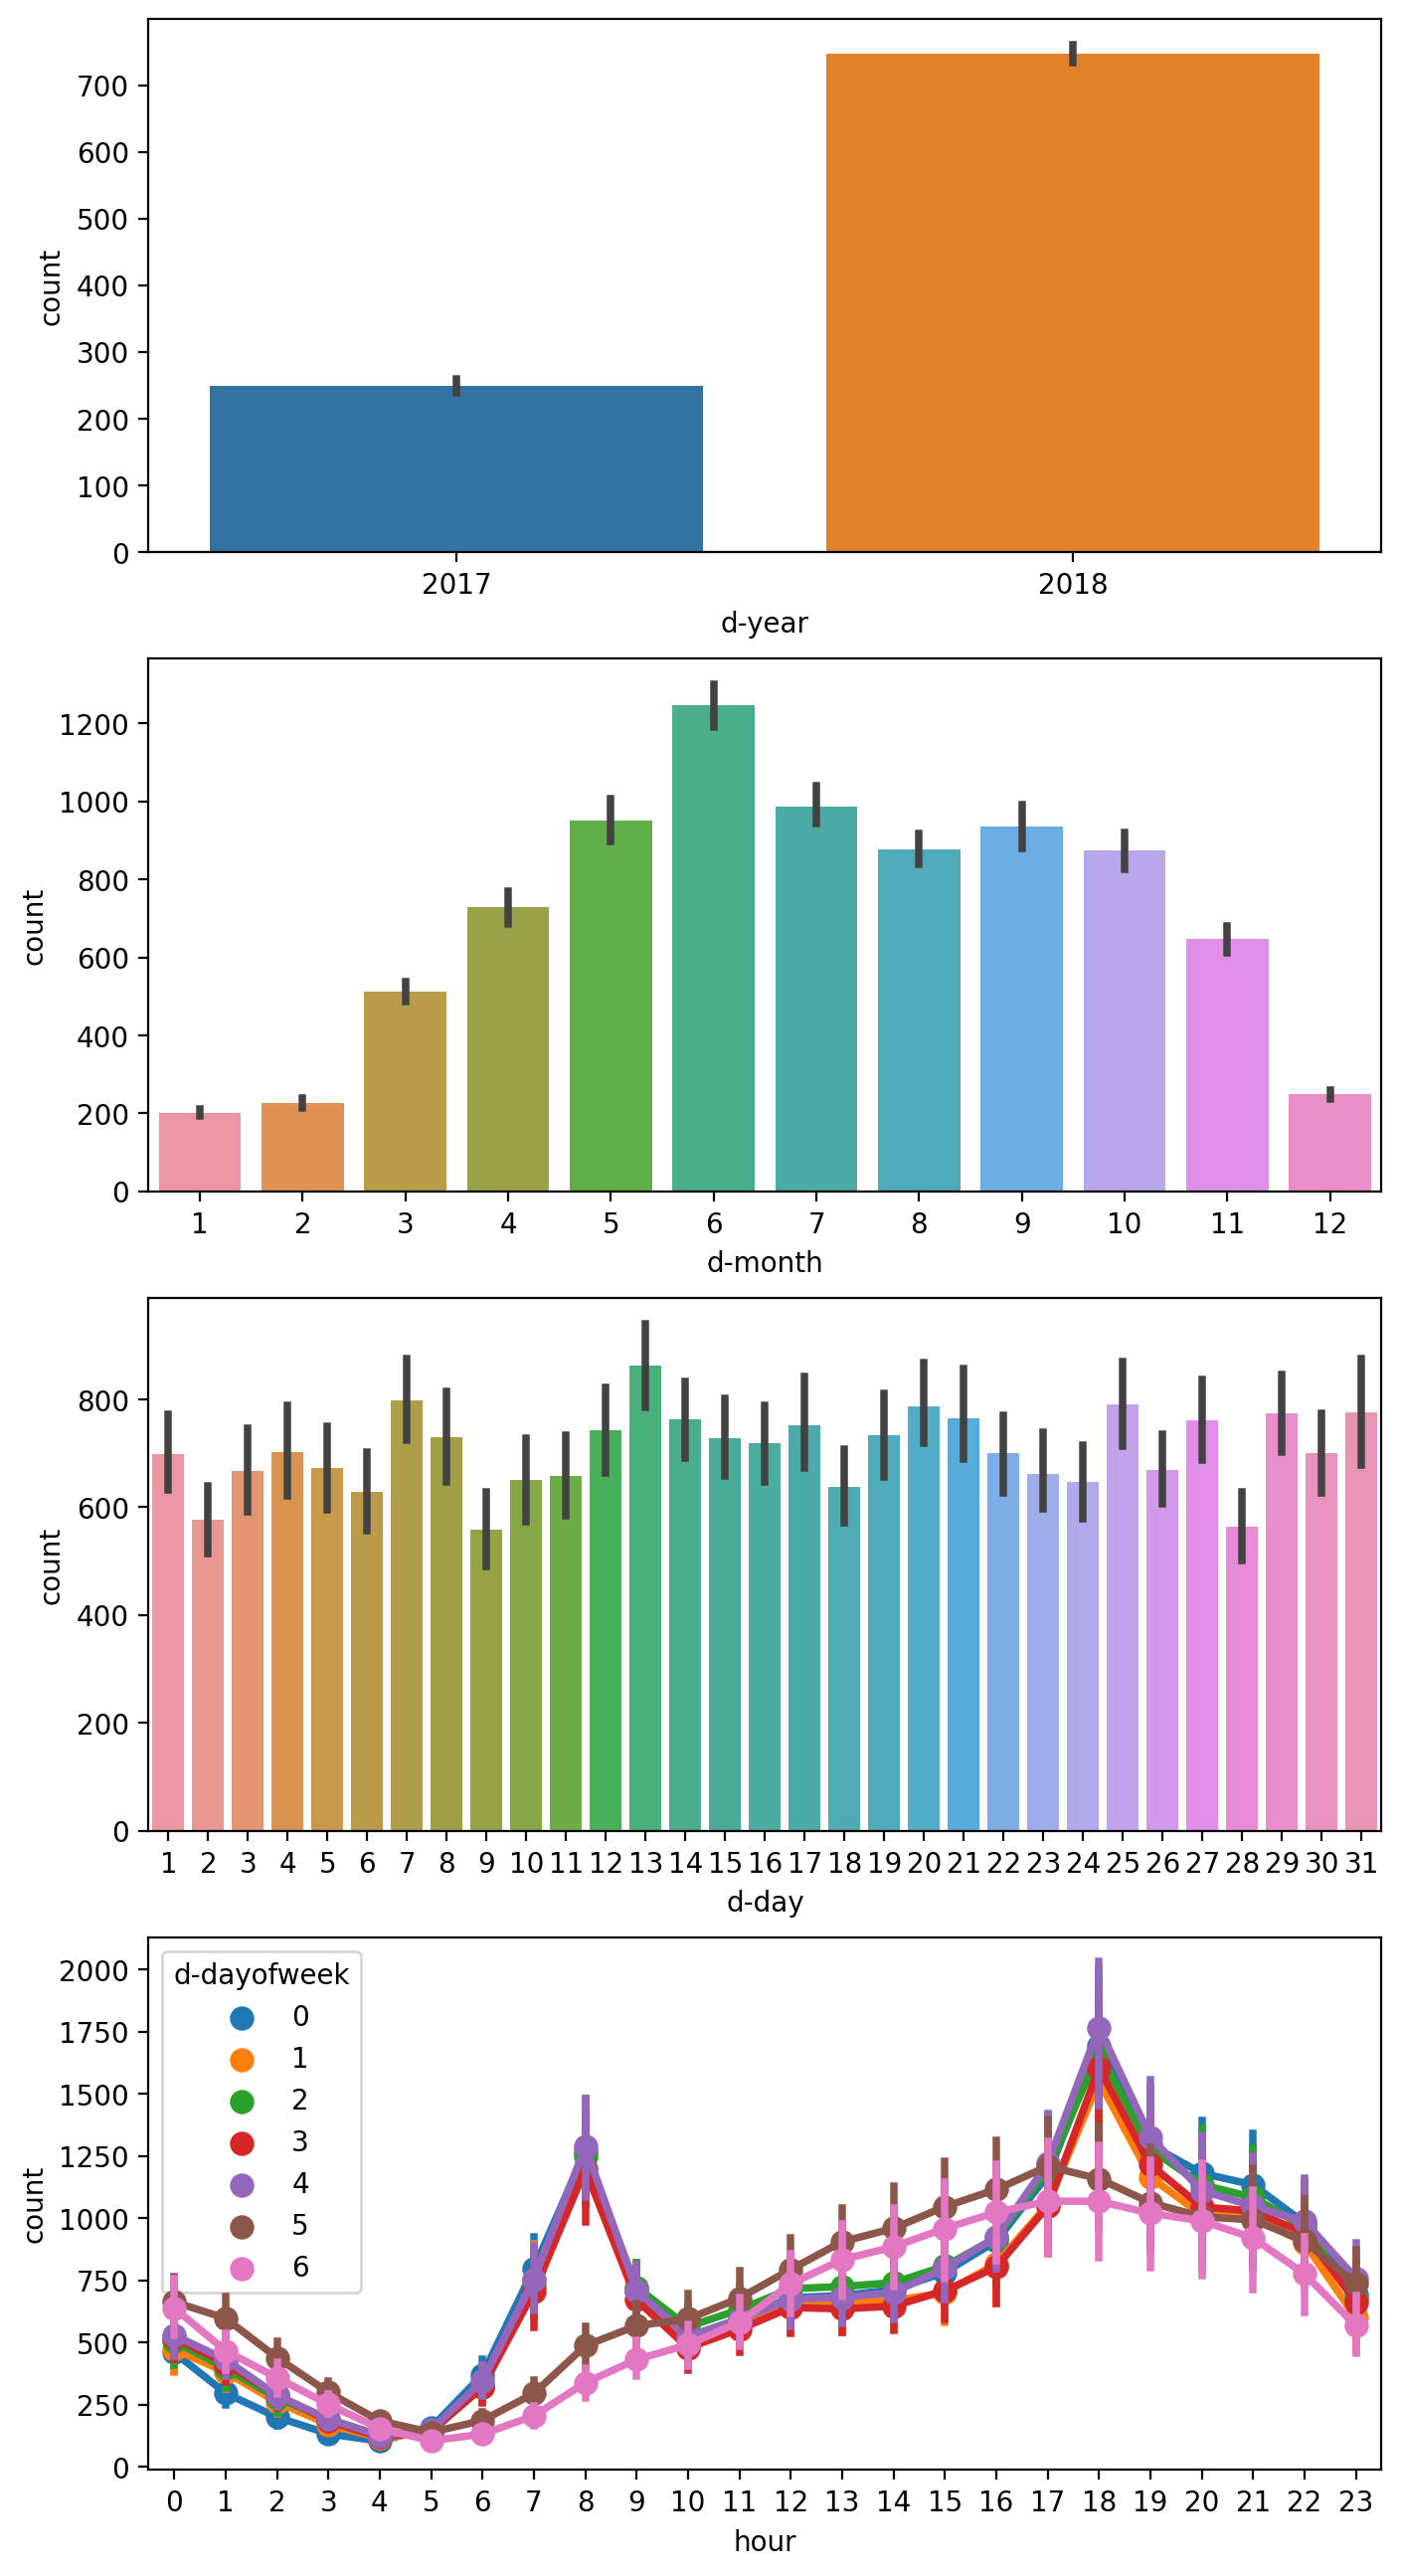

In [29]:
figure, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1,
              figsize=(8,16))
sns.barplot(data=df, x="d-year", y="count", ax=ax1)
sns.barplot(data=df, x="d-month", y="count", ax=ax2)
sns.barplot(data=df, x="d-day", y="count", ax=ax3)
sns.pointplot(data=df, x="hour", y="count", hue="d-dayofweek", ax=ax4)  # 요일(0~6)에 대해서 시간대별로 그린 것. 토/일은 낮에 주로 탐.

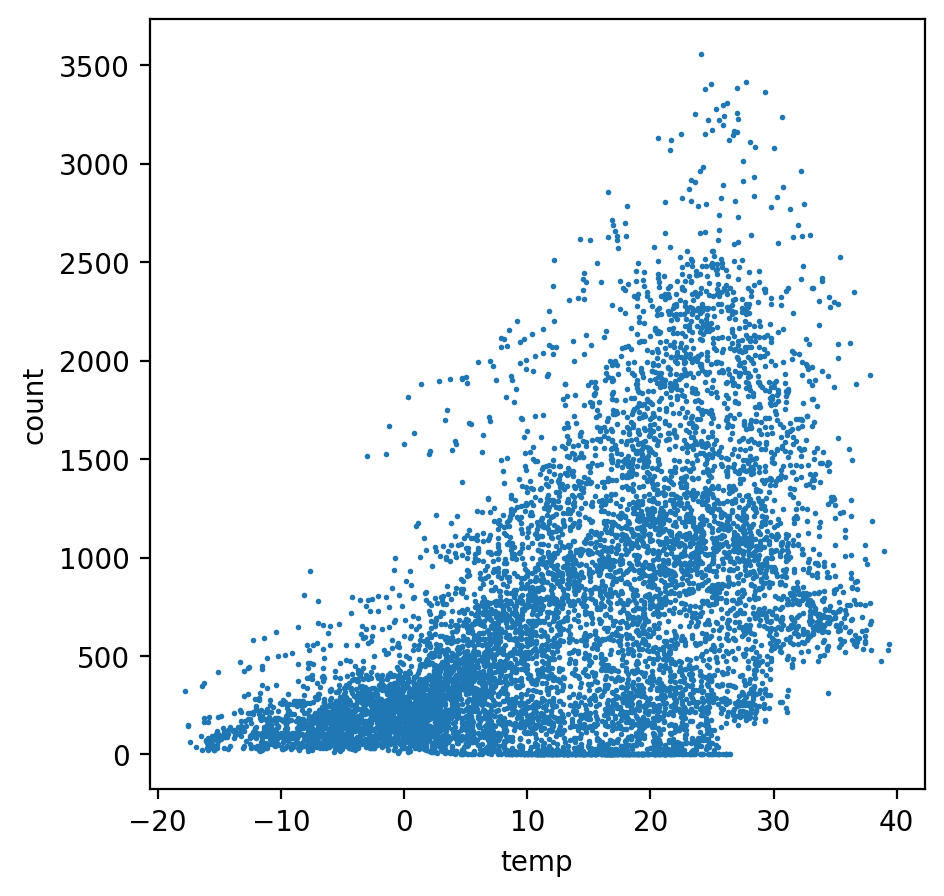

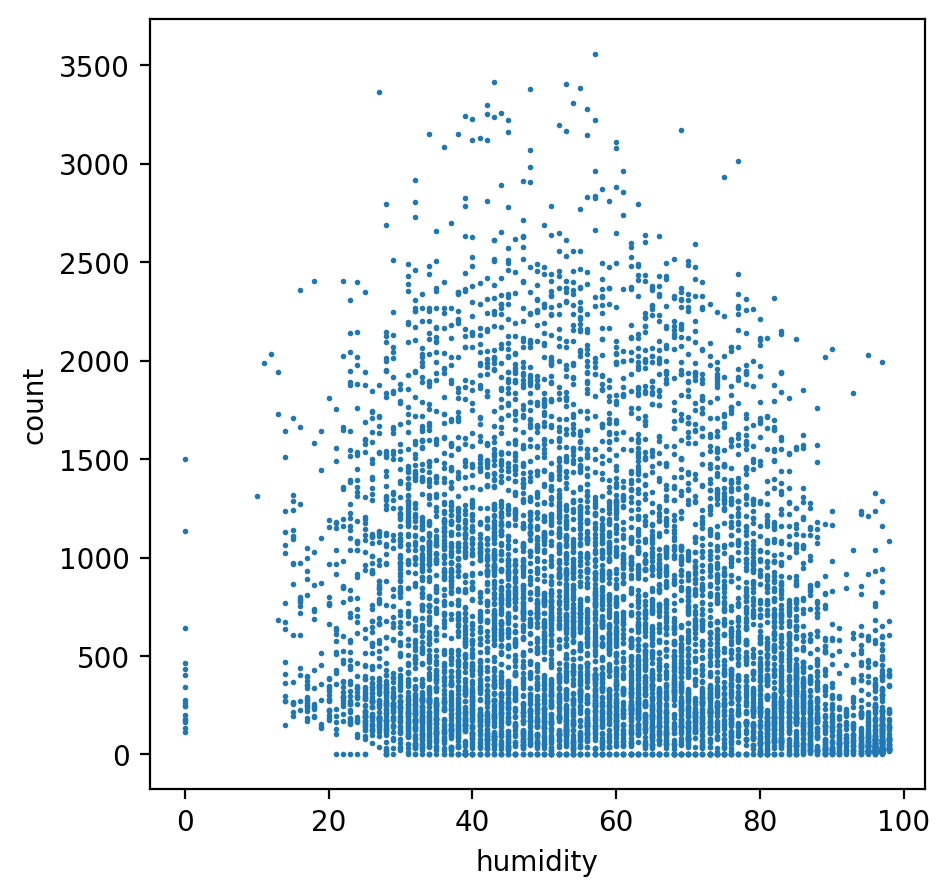

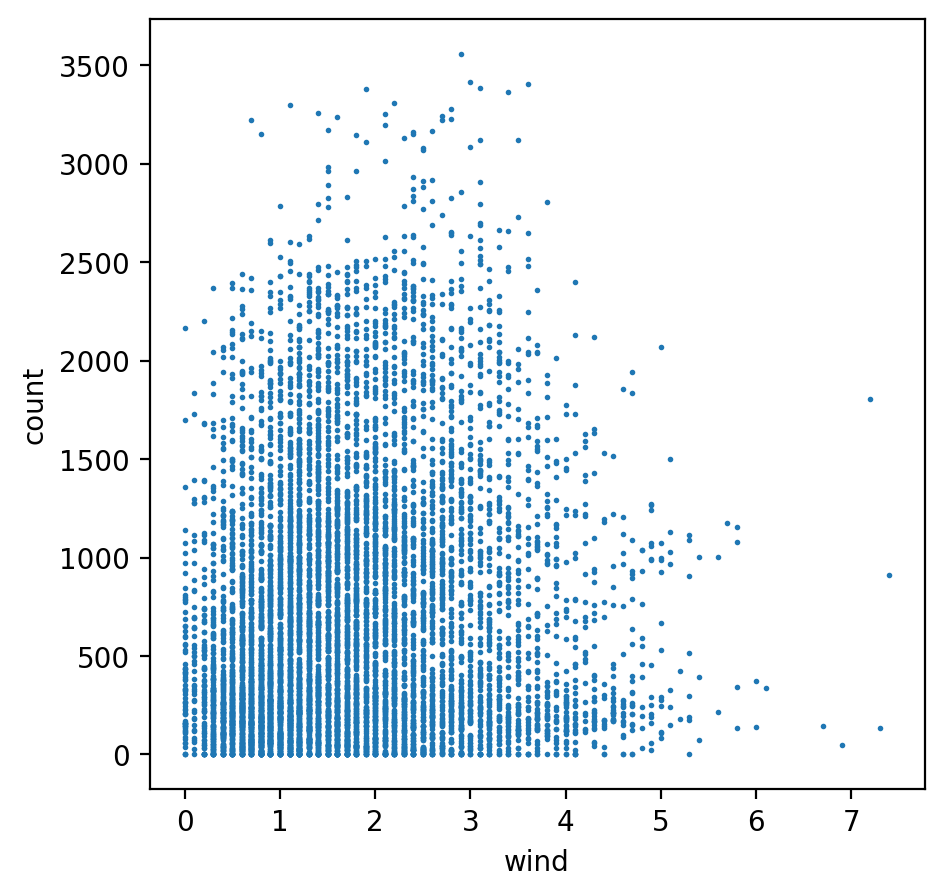

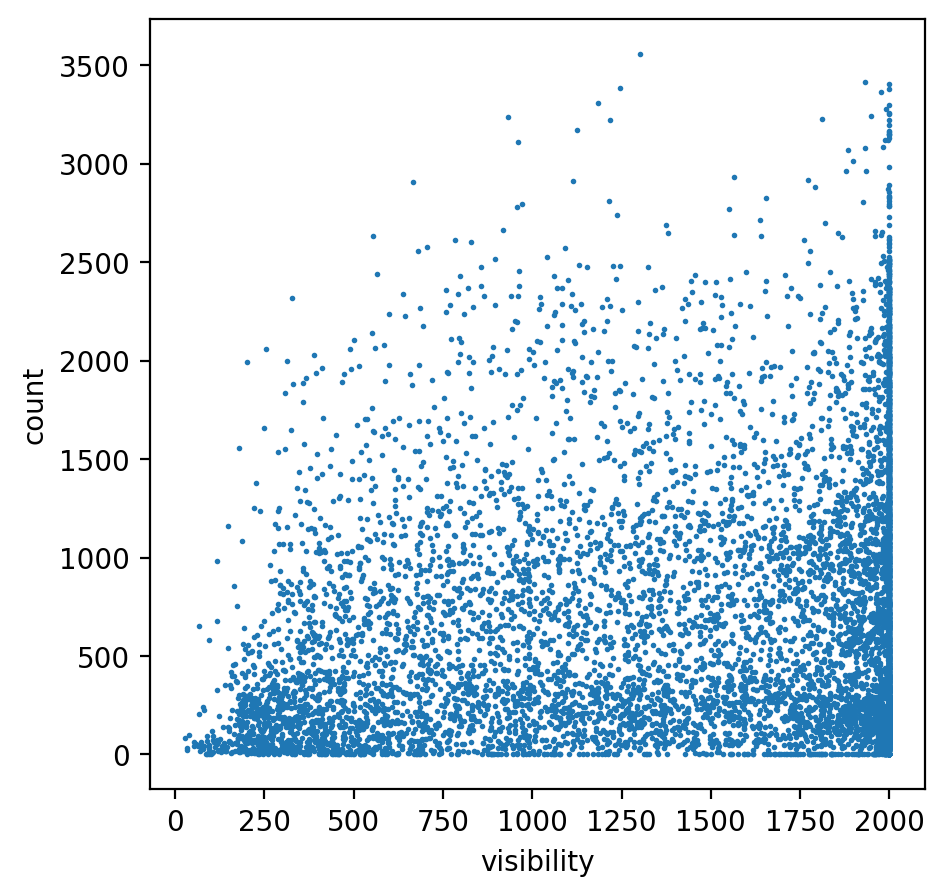

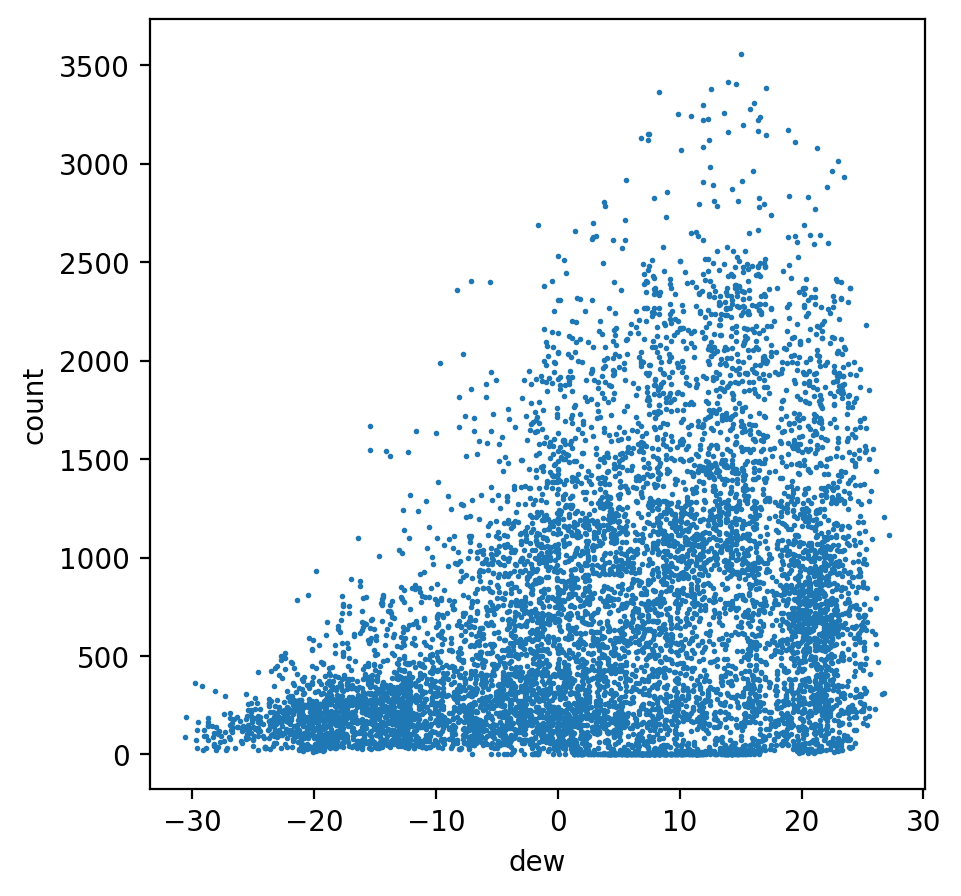

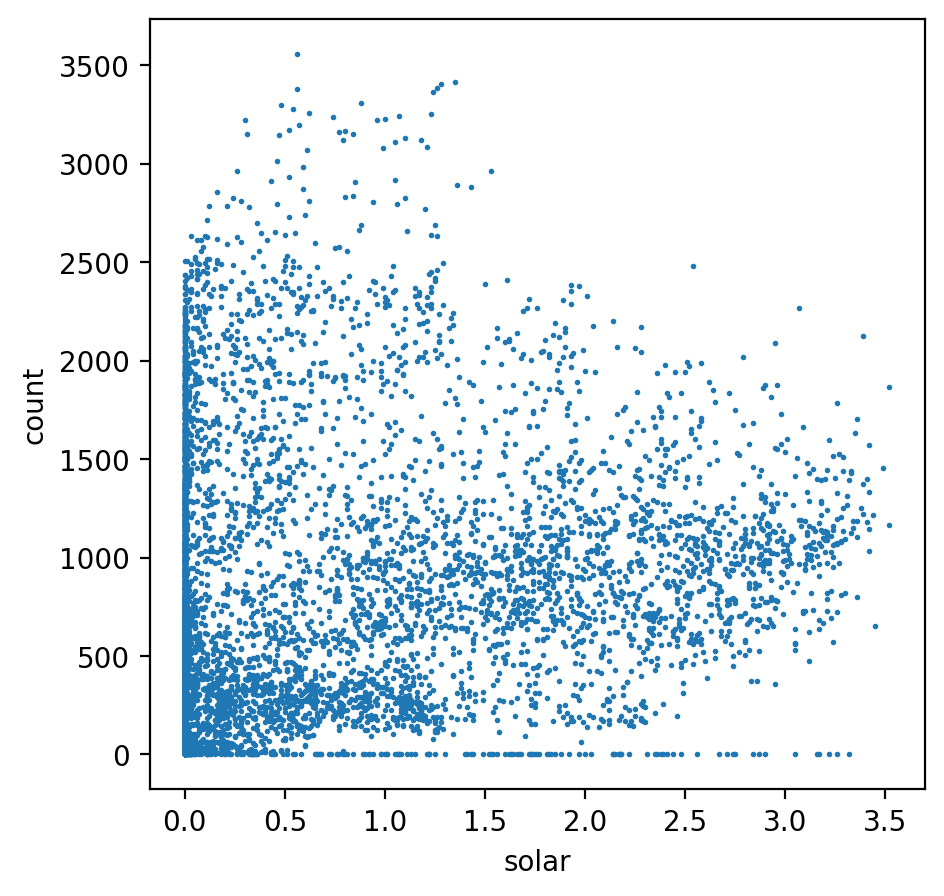

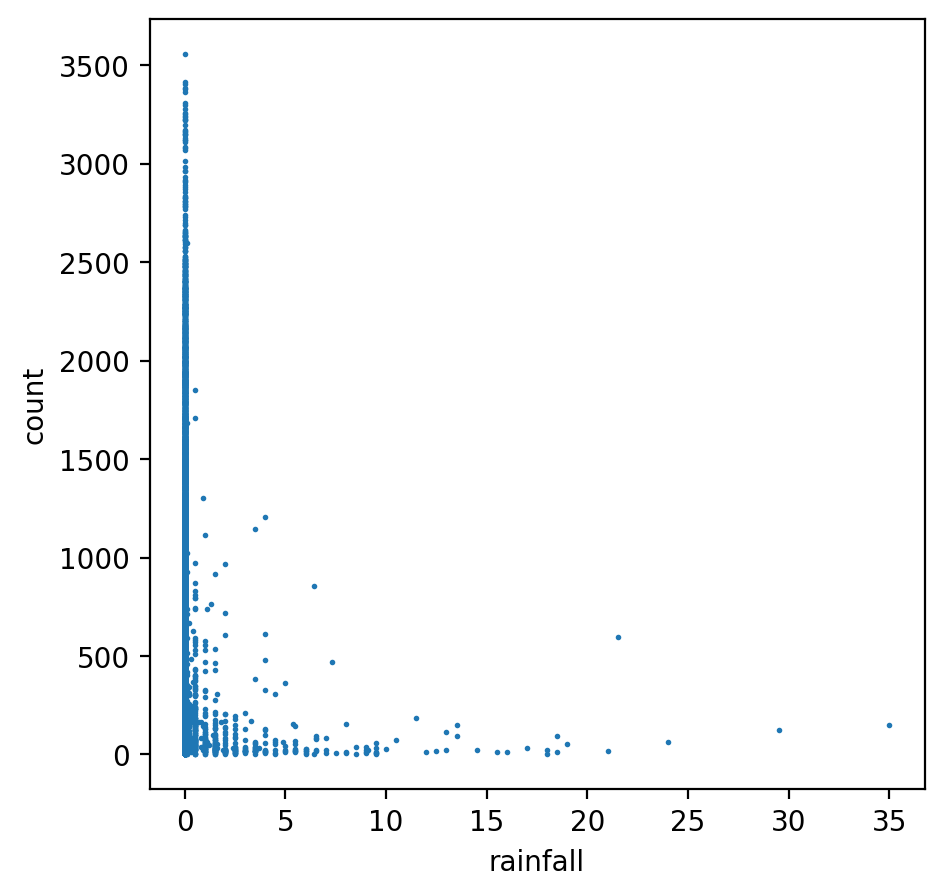

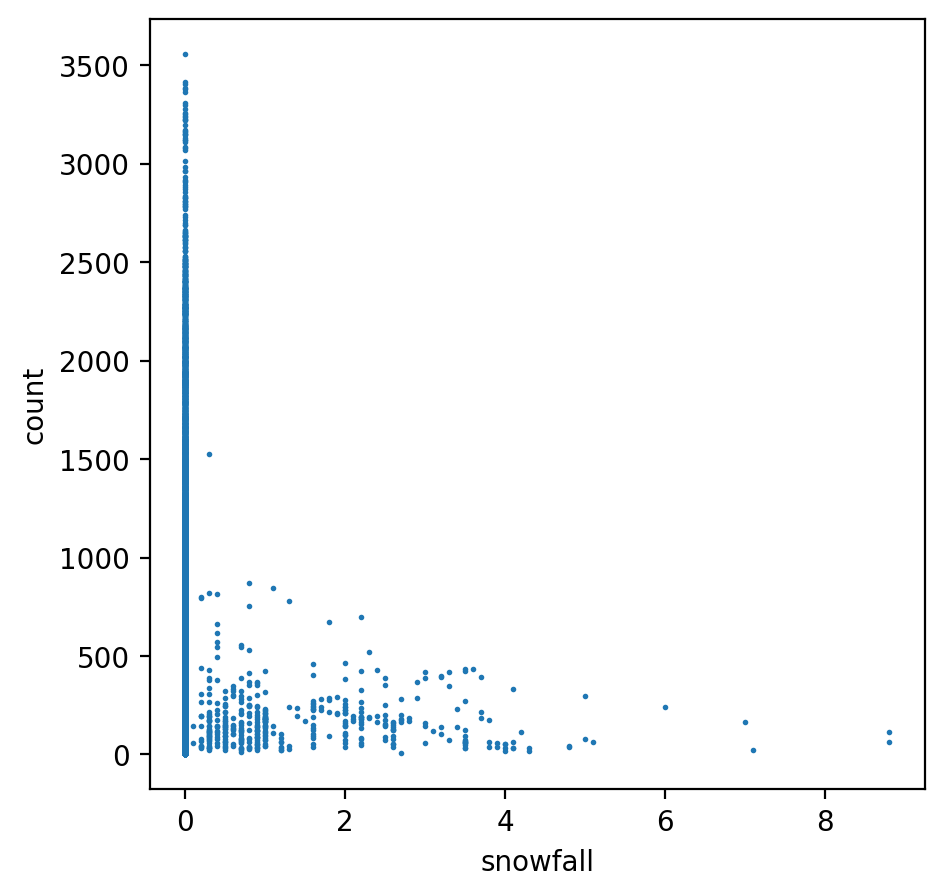

In [30]:
for col in ['temp', 'humidity',
       'wind', 'visibility', 'dew',
       'solar', 'rainfall', 'snowfall']:
    plt.figure(figsize=(5,5))
    plt.scatter(df[col] , df["count"], s=1)
    plt.ylabel('count')
    plt.xlabel(col)
    plt.show()

## 훈련에 사용할 특성 선택

In [31]:
df.columns

Index(['date', 'count', 'hour', 'temp', 'humidity', 'wind', 'visibility',
       'dew', 'solar', 'rainfall', 'snowfall', 'd-year', 'd-month', 'd-day',
       'd-dayofweek', 'seasons_Autumn', 'seasons_Spring', 'seasons_Summer',
       'seasons_Winter', 'holiday_Holiday', 'holiday_No Holiday',
       'functioning_No', 'functioning_Yes'],
      dtype='object')

In [32]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ",
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ",
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ",
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ",
      r2_score(y_test, y_pred).round(3))

In [33]:
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

## 랜덤 포레스트
- 지금은 시계열 데이터 예측이 아니므로 데이터를 셔플링하여 훈련/검증하겠다 (train_test_split)
- 시각 정보(hour)가 유용했다

In [70]:
features = ['hour', 'temp', 'humidity','solar', 'rainfall', 'snowfall', 'd-month',
       'd-dayofweek', 'seasons_Autumn', 'seasons_Spring', 'seasons_Summer',
       'seasons_Winter', 'holiday_Holiday', 'holiday_No Holiday',
       'functioning_No', 'functioning_Yes'] #전체 column을 다 넣어봄.

#맨 밑 문제
features = ['hour','d-dayofweek', 'seasons_Autumn', 'seasons_Spring', 'seasons_Summer',
       'seasons_Winter', 'holiday_Holiday', 'holiday_No Holiday'] #일부 컬럼만 집어넣음.   --> 성능떨어짐..
#성능을 개선하기 위해서 다른 것과 합칠 수 있음. (ex) 3시간전에 몇 개를 빌려갔음.. 값들...

In [71]:
X = df[features]
X[:3]

,hour,d-dayofweek,seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_Holiday,holiday_No Holiday
0,0,4,0,0,0,1,0,1
1,1,4,0,0,0,1,0,1
2,2,4,0,0,0,1,0,1


In [72]:
y = df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y)     #나누면서 Shuffle 이 됨.

In [73]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
show_reg_result(y_test,y_pred)

Max Error:  2530.561
Mean Absolute Error:  281.729
Root Mean Squared Error:  436.534
R-Squared:  0.528


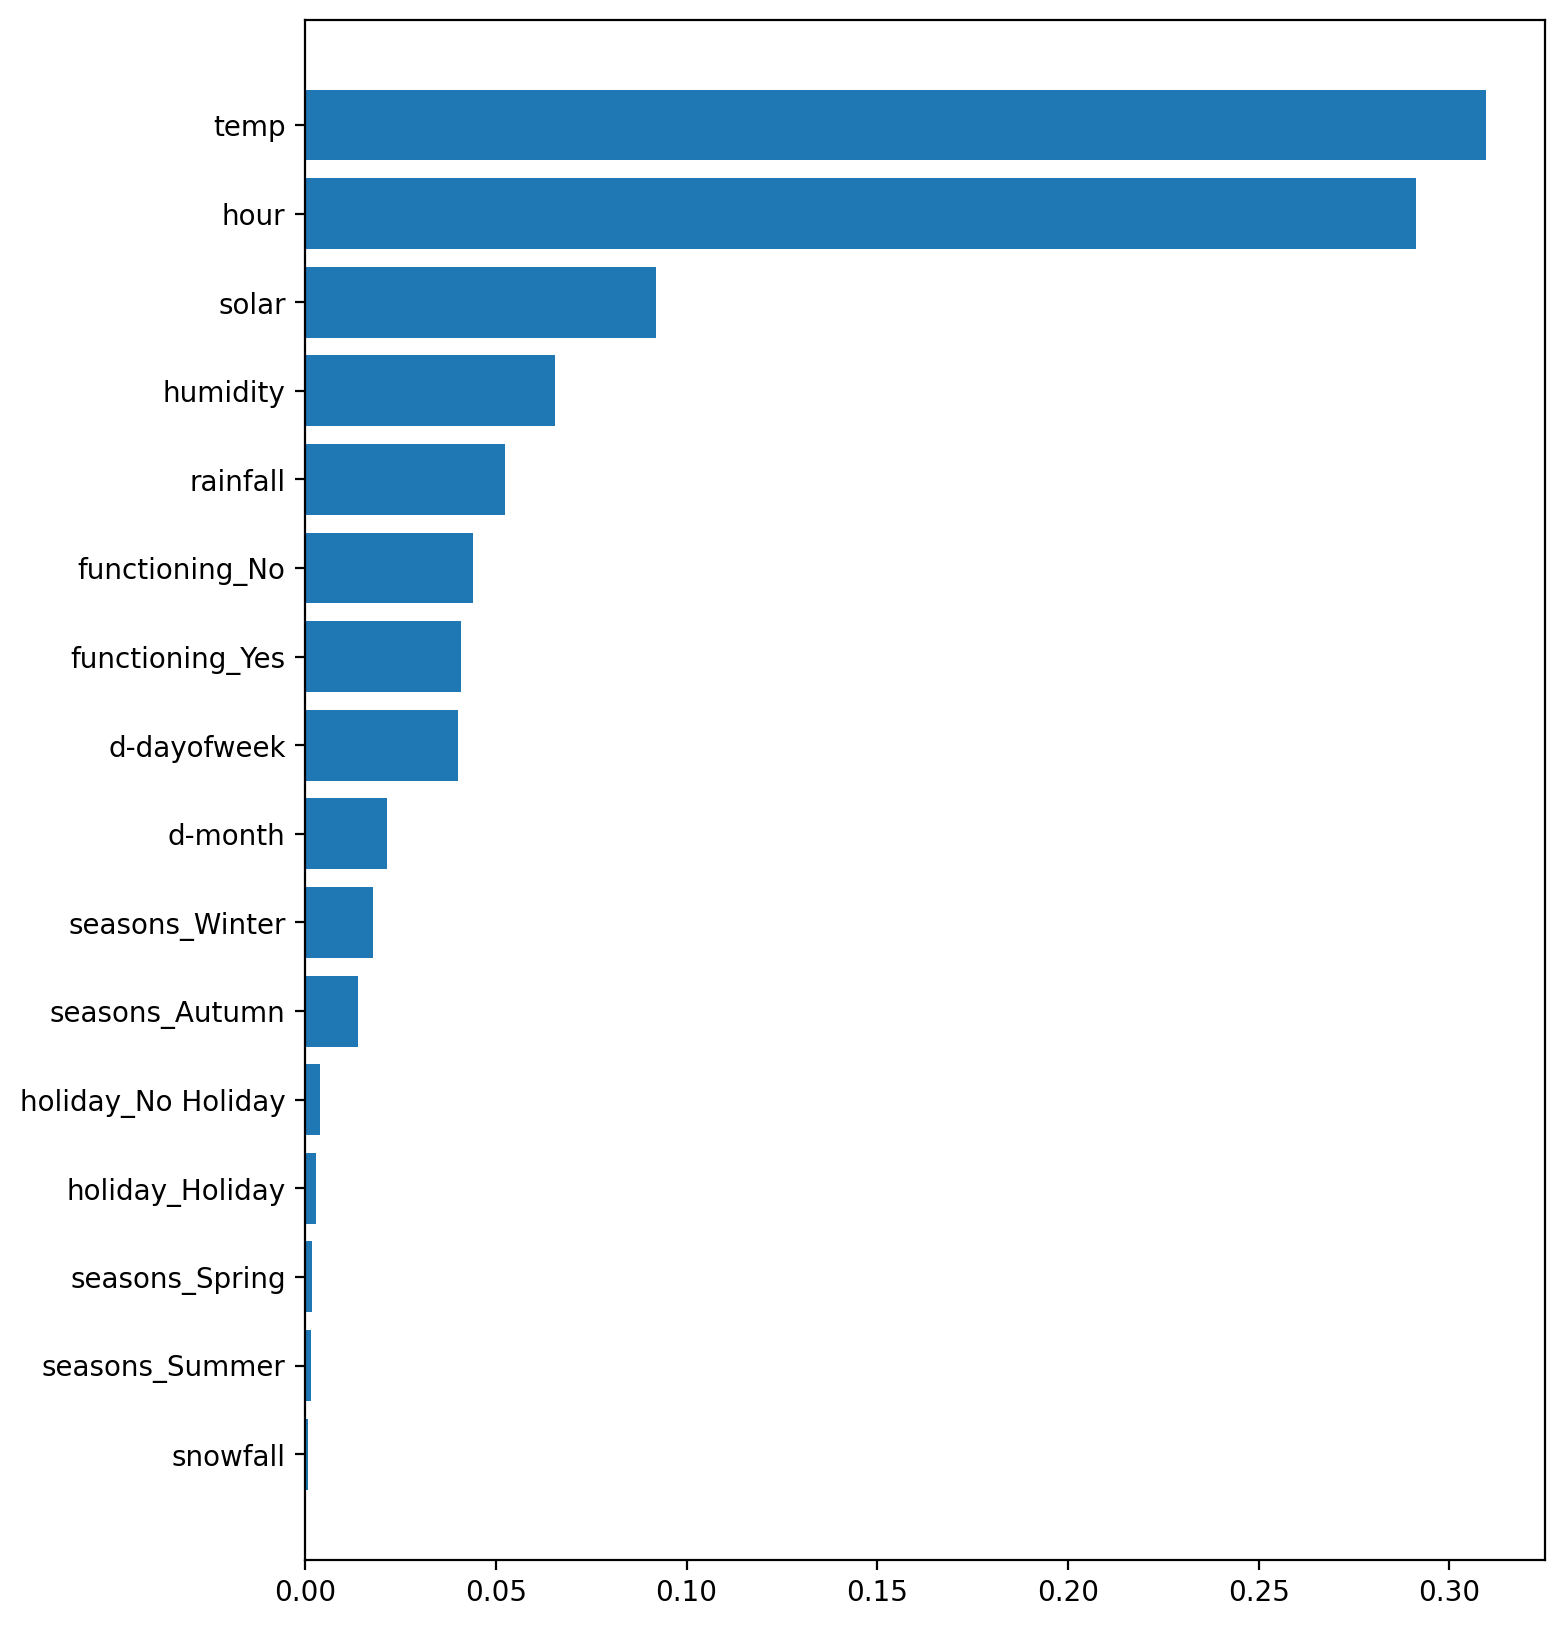

In [39]:
plot_feature_weight(X.columns, model.feature_importances_, N=20) # 어떤 특성이 여기에 영향을 많이 줬는가.

### 주요 특성 변수

In [40]:
def plot_reg_result(y_test, y_pred, N=50):
    y_test=y_test.ravel()
    y_pred=y_pred.ravel()
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_test, y_test-y_pred, s=5)

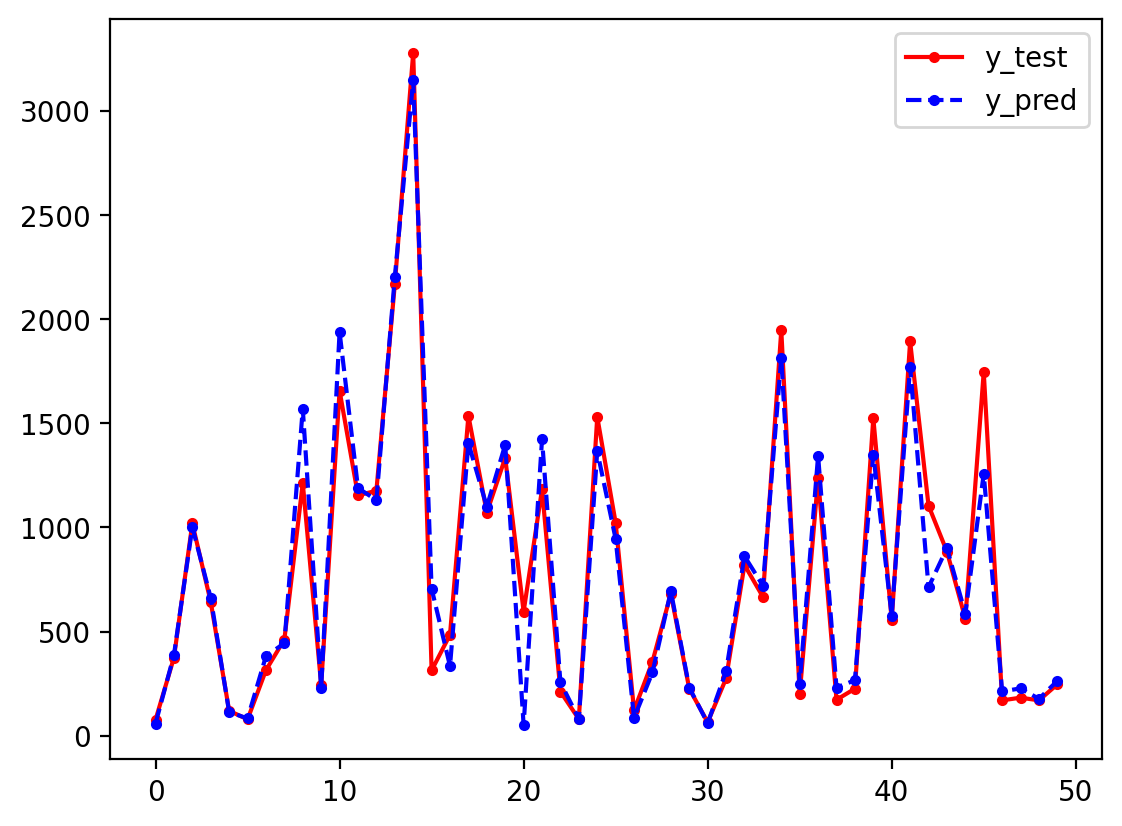

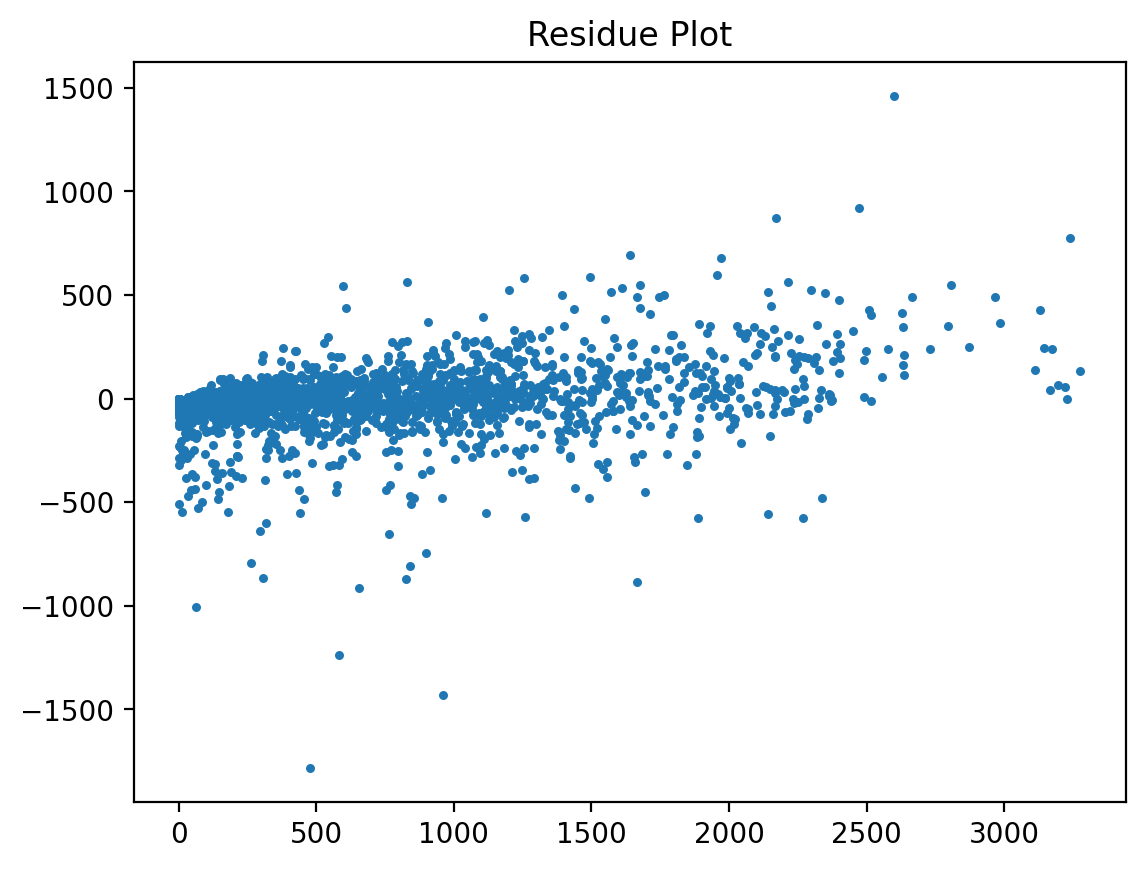

In [43]:
plot_reg_result(y_test, y_pred, N=50)   #R2 가 총체적으로 잘 맞는지, 특정 부분에 안 맞는지를 확인해야함.
# (ex) 반영하지 않은 외부변수 , 공휴일여부.. 이건 별도 반영해주던디 아니면 해당 값은 빼던지.
#그래서 이 데이터를 빼면 성능이 좋아짐.

In [45]:
np.vstack((y_test[:10], y_pred[:10].round(1)))
#np.vstack((y_test[:10], y_pred[:10].round(1))).T

array([[  77. ,  375. , 1019. ,  642. ,  120. ,   79. ,  315. ,  462. ,
        1213. ,  244. ],
       [  58.9,  387.2, 1001.8,  661.4,  113.8,   83.3,  382.4,  444.6,
        1569.8,  229.7]])

## LGBMRegressor

In [ ]:
lgbm_r = LGBMRegressor()
lgbm_r.fit(X_train, y_train)
lgbm_r.score(X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 6570, number of used features: 16
[LightGBM] [Info] Start training from score 702.557839


0.941867115148248

# 특성 선택
- 미래 예측할 날짜의 요일, 공휴일, 시간 등을 알 수 있으나
- 미래의 습도, 풍향 등은 미리 알 수가 없다
- 현실적으로 알 수 있는 특성 값만 사용하는 모데을 만들어 본다

# y-y 모델

- 단변수 시계열 예측

In [61]:
y = df["count"].values
len(y)

8760

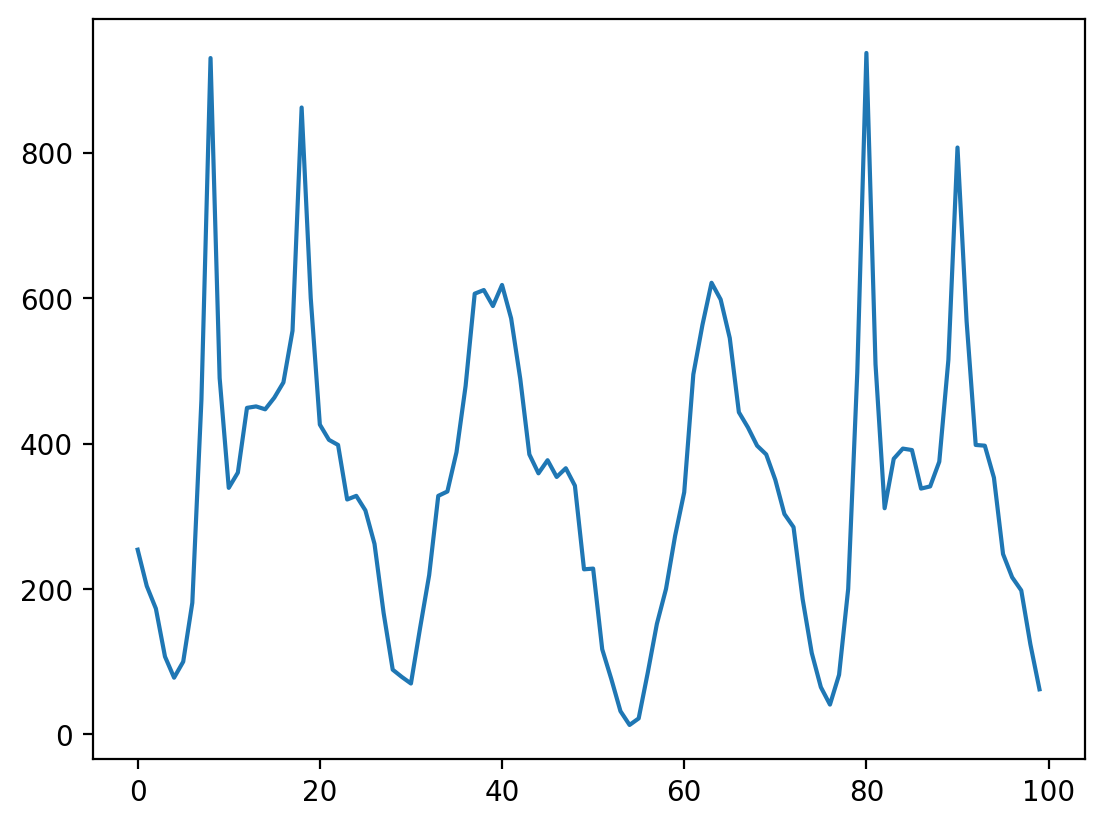

In [62]:
# 시간 단위로 보기
plt.plot(y[:100])

In [63]:
# 앞부분 75%를 훈련 데이터로, 나머지를 검증 데이터로 나누며 순서를 유지한다
train_data, test_data = train_test_split(y, shuffle=False)
len(y), len(train_data), len(test_data)

(8760, 6570, 2190)

In [64]:
def split_seq(sequence, n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        if i > len(sequence) - (n_steps + 1) : break
        x.append(sequence[i:i+n_steps])
        y.append(sequence[i+n_steps])
    return np.array(x), np.array(y)

In [65]:
# 과거 몇개의 샘플을 예측에 사용할 것인지 지정 (윈도우 크기)
model = LinearRegression()
res = []
for n_steps in range(1,300, 3):

    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train)
    res.append((n_steps, model.score(x_test, y_test).round(4))) # R2 값

<Axes: xlabel='time'>

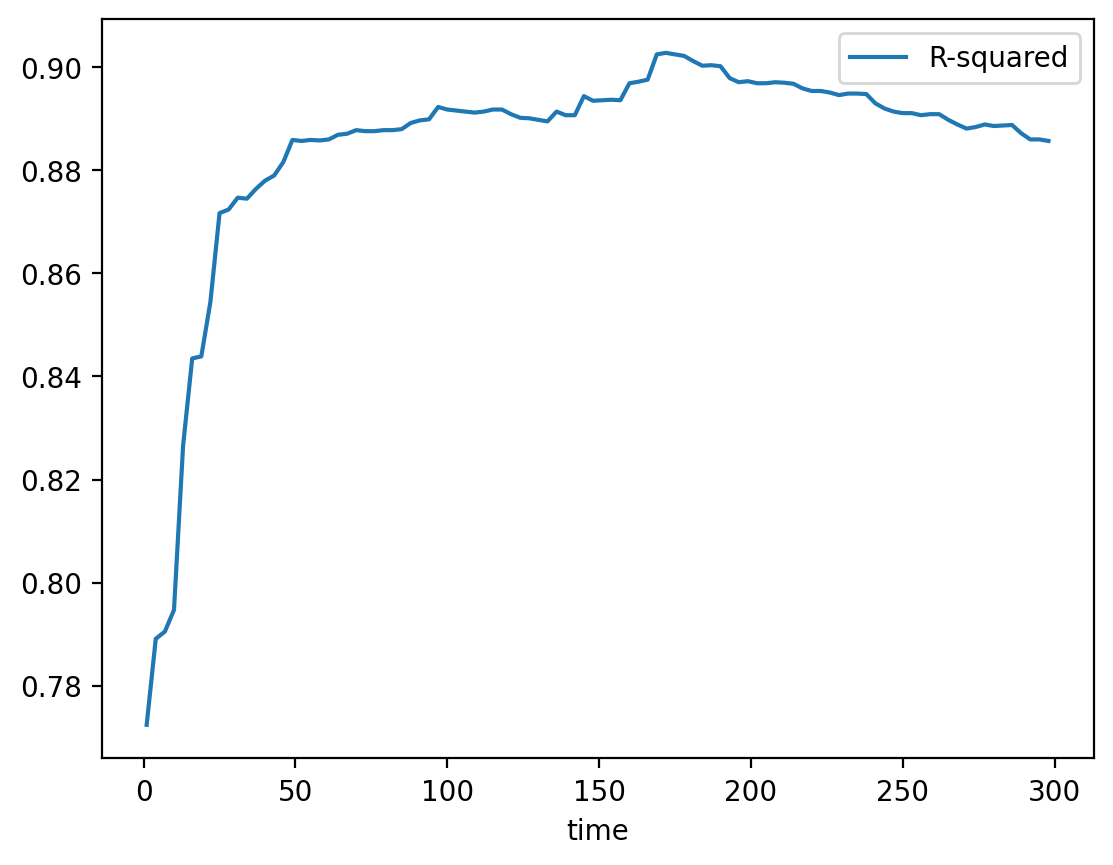

In [51]:
df_r = pd.DataFrame(res, columns=['time','R-squared']).set_index('time')
df_r.plot() #결과를 보면 한 160 정도가 제일 성능이 good.

In [ ]:
df_r.idxmax(), df_r.max()  #가장 최적의 값이 나오는 index 를 찾아라...

(R-squared    172
 dtype: int64,
 R-squared    0.9028
 dtype: float64)

## 먼 미래 예측

In [54]:
# 입력 윈도우 n_steps_in, 멀티스텝 출력 n_steps_out
def split_seq_2(sequence, n_steps_in, n_steps_out):
  x, y = [],[] #빈 리스트만들기
  for i in range(len(sequence)):   #전체를 쭉-  for문
    end_ix = i + n_steps_in #시작점 (윈도우의 )
    out_end_ix = end_ix + n_steps_out   #끝점  (윈도우의 )
    if out_end_ix > len(sequence):  #윈도우 끝점이 전체 길이보다 커질경우, 끝냄.
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]     #윈도우 x (input),
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y)

In [55]:
z = np.arange(15)
split_seq_2(z, 6 ,2)  #과거 6개를 보고 2칸 떨어진.. 값을 맞춘다... 0~5까지 보고, 7 을 본다.

(array([[ 0,  1,  2,  3,  4,  5],
        [ 1,  2,  3,  4,  5,  6],
        [ 2,  3,  4,  5,  6,  7],
        [ 3,  4,  5,  6,  7,  8],
        [ 4,  5,  6,  7,  8,  9],
        [ 5,  6,  7,  8,  9, 10],
        [ 6,  7,  8,  9, 10, 11],
        [ 7,  8,  9, 10, 11, 12]]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14]))

In [56]:
# 먼 미래 예측
n_steps = 172  #172개를 보고 하는데, feature를 73 (0~72, 3일치니까 72시간으로), 미래를 3일후까지 맞추는데, 3시간 간격으로

res = []
for n_future in range(1,73, 3):

    x_train, y_train = split_seq_2(train_data, n_steps, n_future)
    x_test, y_test = split_seq_2(test_data, n_steps, n_future)
    model.fit(x_train, y_train)
    res.append((n_future, model.score(x_test, y_test).round(4))) # R2 값

<Axes: xlabel='time'>

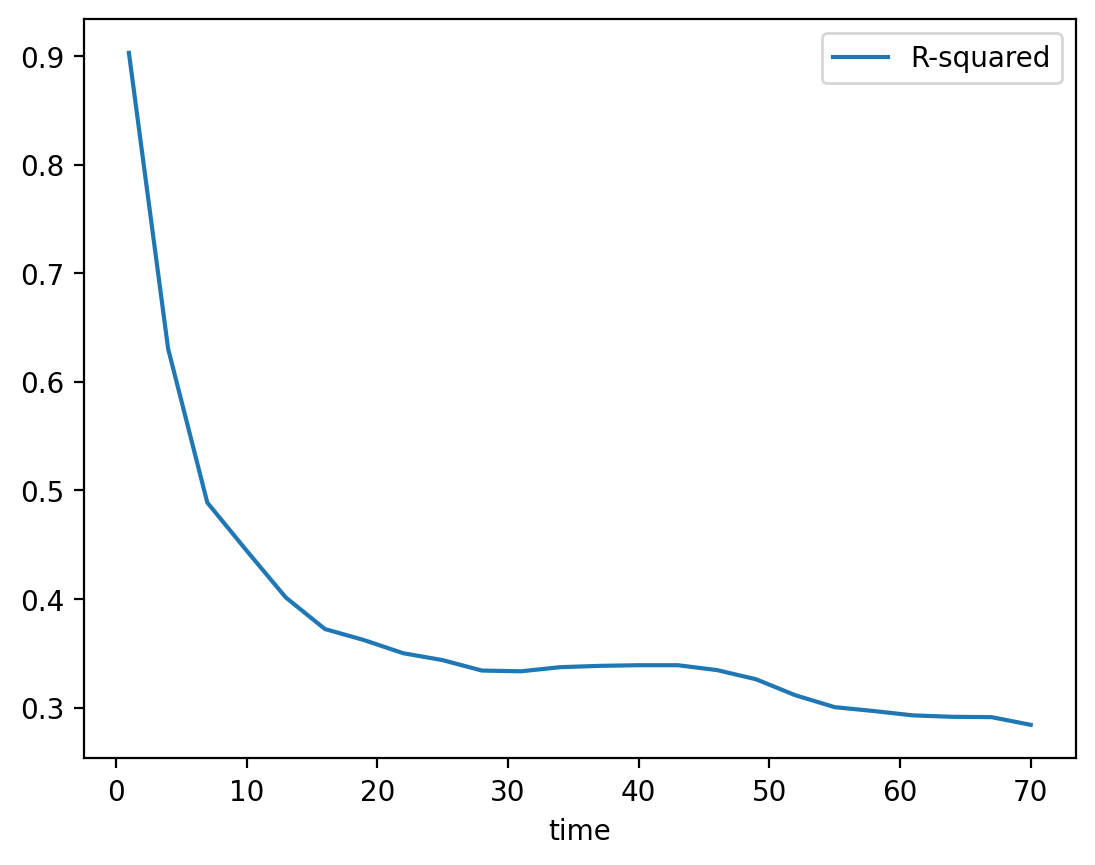

In [57]:
df_r = pd.DataFrame(res, columns=['time','R-squared']).set_index('time')
df_r.plot()

# 일 단위 예측

In [58]:
df_down = df.set_index("date").resample('D').mean()
print(df_down.shape)
df_down[:3]

(365, 22)


,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,snowfall,...,d-day,d-dayofweek,seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_Holiday,holiday_No Holiday,functioning_No,functioning_Yes
date,,,,,,,,,,,,,,,,,,,,,
2017-12-01,397.458333,11.5,-2.454167,45.875000,1.5375,1870.750000,-13.545833,0.248750,0.000000,0.0,...,1.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2017-12-02,355.125000,11.5,1.325000,61.958333,1.7125,1471.083333,-5.716667,0.263750,0.000000,0.0,...,2.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2017-12-03,300.916667,11.5,4.875000,81.541667,1.6125,455.750000,1.883333,0.125417,0.166667,0.0,...,3.0,6.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


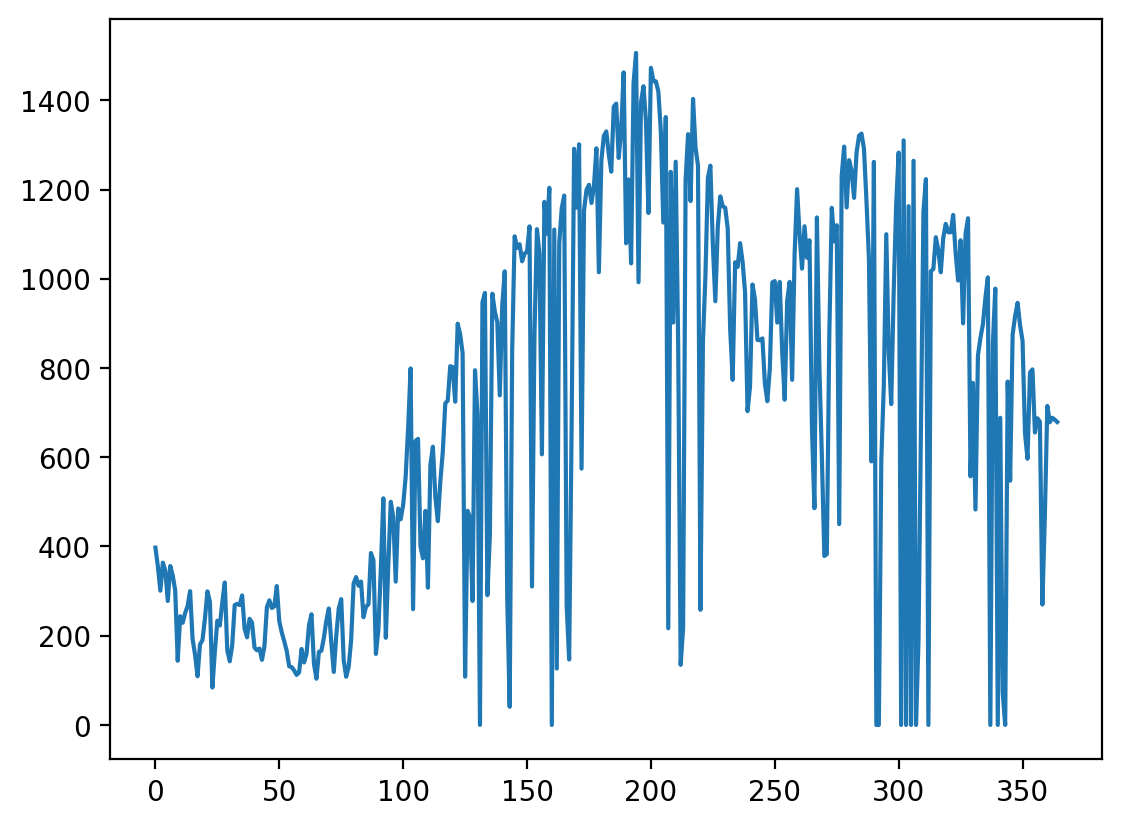

In [59]:
# 일 단위로 보기
count_d = df_down["count"].values
plt.plot(count_d)

In [ ]:
#문제  X-y 모델에서 특성을 현실적으로 예상가능한 값만 사용하시오.

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score
from datetime import datetime
%config InlineBackend.figure_format = 'retina'
import matplotlib

In [65]:



#우리 자료  TEST 해보기  얏후
#https://github.com/coj918/github_from_HD/blob/main/Performance_v2.csv
#https://raw.githubusercontent.com/coj918/github_from_HD/master/Performance_v2.csv



#df = pd.read_csv("https://raw.githubusercontent.com/coj918/github_from_HD/master/Performance_v2.csv", header=None)
df = pd.read_csv("https://raw.githubusercontent.com/coj918/github_from_HD/master/Performance_v2.csv",parse_dates=['YEAR_MONTH'])
#df.set_index("YEAR_MONTH", inplace=True)


#df = pd.get_dummies(df, columns=['CB_TYPE','VSL_TYPE','TC_TYPE'])

print(df.shape)
df[:3]
df[:]

(2929, 13)


,NO,YEAR_MONTH,CB_TYPE,VSL_TYPE,TC_TYPE,CB_TEAM_CODE,CB_INDEX,DUR,BNK_PRC,DAY_CB,DAY_HIRE,TC_INDEX,PL
0,1,201501,TR,Cape,OWNED,63,627,129.004,462.60,10061,0,0,10061
1,2,201501,TR,Cape,OWNED,64,627,562.834,511.25,27394,0,0,27394
2,3,201501,TR,Handy,OWNED,39,416,24.879,349.01,7539,0,0,7539
3,4,201501,TR,Handy,OWNED,165,416,62.000,583.10,28880,0,0,28880
4,5,201501,TR,Handy,OWNED,231,416,23.521,511.63,5012,0,0,5012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,2925,202308,LN,S'max,TC,231,805,153.845,0.00,8717,11592,8860,-2875
2925,2926,202308,TR,S'max,TC,233,805,230.793,600.51,12622,11133,8860,1489
2926,2927,202308,LN,S'max,TC,282,805,615.183,606.55,6995,8049,8860,-1054
2927,2928,202308,LN,S'max,TC,283,805,138.415,605.89,7022,6332,8860,690


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NO            2929 non-null   int64  
 1   YEAR_MONTH    2929 non-null   object 
 2   CB_TYPE       2929 non-null   object 
 3   VSL_TYPE      2929 non-null   object 
 4   TC_TYPE       2929 non-null   object 
 5   CB_TEAM_CODE  2929 non-null   int64  
 6   CB_INDEX      2929 non-null   int64  
 7   DUR           2929 non-null   float64
 8   BNK_PRC       2929 non-null   float64
 9   DAY_CB        2929 non-null   int64  
 10  DAY_HIRE      2929 non-null   int64  
 11  TC_INDEX      2929 non-null   int64  
 12  PL            2929 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 297.6+ KB


In [23]:
df.isnull().sum().sum()

0

In [67]:
#features = ['YEAR_MONTH','CB_TYPE', 'VSL_TYPE', 'TC_TYPE', 'CB_TEAM_CODE','CB_INDEX', 'DUR', 'BNK_PRC','TC_INDEX']
features = ['YEAR_MONTH', 'CB_TEAM_CODE','CB_INDEX', 'DUR', 'BNK_PRC','TC_INDEX']

In [68]:
X = df[features]

X[:3]


,YEAR_MONTH,CB_TEAM_CODE,CB_INDEX,DUR,BNK_PRC,TC_INDEX
0,201501,63,627,129.004,462.60,0
1,201501,64,627,562.834,511.25,0
2,201501,39,416,24.879,349.01,0


In [69]:
X = pd.get_dummies(df, columns=['CB_TYPE','VSL_TYPE','TC_TYPE'])
X[:3]


,NO,YEAR_MONTH,CB_TEAM_CODE,CB_INDEX,DUR,BNK_PRC,DAY_CB,DAY_HIRE,TC_INDEX,PL,CB_TYPE_LN,CB_TYPE_TR,VSL_TYPE_Cape,VSL_TYPE_Handy,VSL_TYPE_P'max,VSL_TYPE_S'max,TC_TYPE_OWNED,TC_TYPE_TC
0,1,201501,63,627,129.004,462.60,10061,0,0,10061,0,1,1,0,0,0,1,0
1,2,201501,64,627,562.834,511.25,27394,0,0,27394,0,1,1,0,0,0,1,0
2,3,201501,39,416,24.879,349.01,7539,0,0,7539,0,1,0,1,0,0,1,0


In [70]:
X.set_index("YEAR_MONTH", inplace=True)

X[:3]

,NO,CB_TEAM_CODE,CB_INDEX,DUR,BNK_PRC,DAY_CB,DAY_HIRE,TC_INDEX,PL,CB_TYPE_LN,CB_TYPE_TR,VSL_TYPE_Cape,VSL_TYPE_Handy,VSL_TYPE_P'max,VSL_TYPE_S'max,TC_TYPE_OWNED,TC_TYPE_TC
YEAR_MONTH,,,,,,,,,,,,,,,,,
201501,1,63,627,129.004,462.60,10061,0,0,10061,0,1,1,0,0,0,1,0
201501,2,64,627,562.834,511.25,27394,0,0,27394,0,1,1,0,0,0,1,0
201501,3,39,416,24.879,349.01,7539,0,0,7539,0,1,0,1,0,0,1,0


In [71]:
X = X.drop(["DAY_CB"], axis=1)
X = X.drop(["DAY_HIRE"], axis=1)
X[:3]

,NO,CB_TEAM_CODE,CB_INDEX,DUR,BNK_PRC,TC_INDEX,PL,CB_TYPE_LN,CB_TYPE_TR,VSL_TYPE_Cape,VSL_TYPE_Handy,VSL_TYPE_P'max,VSL_TYPE_S'max,TC_TYPE_OWNED,TC_TYPE_TC
YEAR_MONTH,,,,,,,,,,,,,,,
201501,1,63,627,129.004,462.60,0,10061,0,1,1,0,0,0,1,0
201501,2,64,627,562.834,511.25,0,27394,0,1,1,0,0,0,1,0
201501,3,39,416,24.879,349.01,0,7539,0,1,0,1,0,0,1,0


In [ ]:
#X2 = X.drop(["big"], axis=1)

In [72]:
y = df['DAY_CB']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)     #나누면서 Shuffle 이 됨.

In [73]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ",
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ",
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ",
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ",
      r2_score(y_test, y_pred).round(3))

In [74]:
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

In [75]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
show_reg_result(y_test,y_pred)

Max Error:  131921.94
Mean Absolute Error:  4919.488
Root Mean Squared Error:  11728.324
R-Squared:  0.291


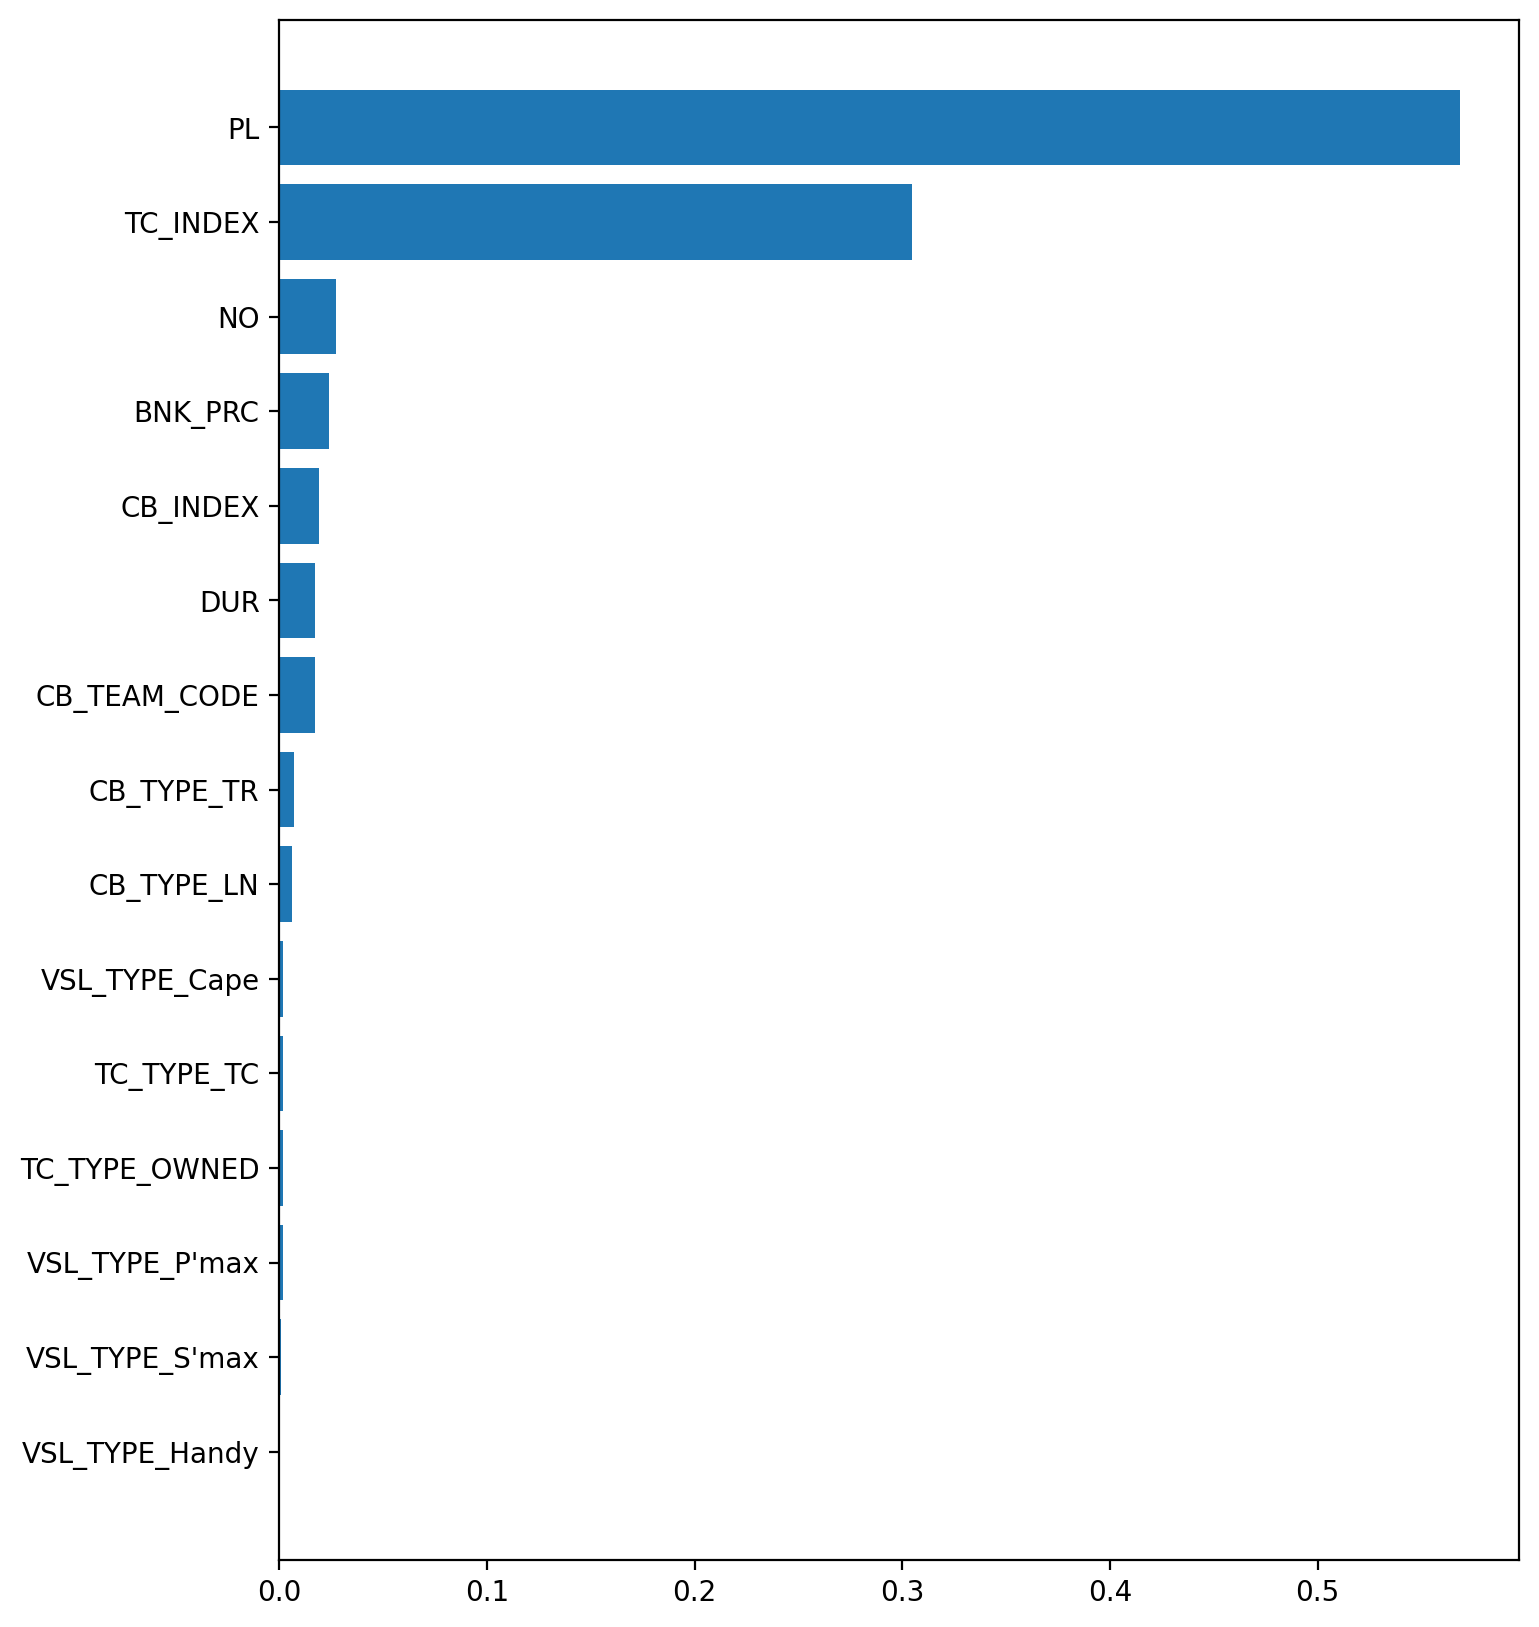

In [76]:
plot_feature_weight(X.columns, model.feature_importances_, N=20) # 어떤 특성이 여기에 영향을 많이 줬는가.